## Grandient Boosting Modeling for Math ##

The models are:
- CatBoost
- XGBoost
- LightGBM
- HistGradientBoosting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# import warnings 
# warnings.filterwarnings('ignore')

# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score

### Prepare data ###

Loading the data cleaned from [Task1_Data_Integration.ipynb](../EDA/Task1_Data_Integration.ipynb)

In [3]:
df = pd.read_csv('../EDA/DATA_Texas_District_v2.csv', sep=',', header=0)
print(df.shape)

(955, 90)


Loading the Feature Selection result report from [Task3_Feature_Selection_Math.ipynb](../EDA/Task3_Feature_Selection_Math.ipynb)

In [4]:
report = pd.read_csv('../EDA/Task3_Feature_Selection_Math_Report.csv', sep=',', header=0)
report = report.sort_values(by=['MCC', 'F1'], ascending=False, ignore_index=True)
print(report.shape)

(85, 11)


**Get dummies for categorical feature `Locale`**

In [5]:
df = pd.get_dummies(df, columns=['Locale'], prefix='Locale')
print(df.shape)

(955, 101)


**Split data**

In [6]:
labels = ['Label_Math', 'Label_Reading', 'Label_All']
cols_drop = ['% Tested Reading G3 Diff',
            '% Tested Reading G4 Diff',
            '% Tested Reading G5 Diff',
            '% Tested Reading G6 Diff',
            '% Tested Reading G7 Diff',
            '% Tested Reading G8 Diff',
            'District #', 'County #']

df['Label'] = df['Label_Math'].apply(lambda x: 0 if x == -1
                                             else 1 if x == 0
                                             else 2)

y = df['Label'].values
X = df.drop(columns=labels + cols_drop + ['Label']).copy()
columns = df.drop(columns=labels + cols_drop + ['Label']).columns.to_list()
categorical_cols = [c for c in columns if 'Locale' in c]
categorical_cols_idx = [columns.index(c) for c in columns if 'Locale' in c]
numerical_cols = [c for c in columns if c not in categorical_cols]

random_state=123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=random_state, shuffle=True)
print(X.shape)

(955, 90)


In [7]:
values, counts = np.unique(y_train, return_counts=True)
values_test, counts_test = np.unique(y_test, return_counts=True)
pd.DataFrame({'Label': values.tolist(), 'Train': counts.tolist(), 'Test': counts_test.tolist()})

,Label,Train,Test
0,0,166,41
1,1,412,103
2,2,186,47


**Normalization**

In [8]:
scaler = StandardScaler()

scaler.fit(X_train[numerical_cols])
X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

### Experiment with the Feature Sets selected from [Task3_Feature_Selection_Math.ipynb](../EDA/Task3_Feature_Selection_Math.ipynb) ###

In [9]:
print('Feature Set 1 (Original Set)')
print('\tn features:', len(columns))

feature_set = report[(report['model'] == 'Ridge') & (report['type'] == 'by methods')].sort_values(by=['n Selected'], ignore_index=True)
n = feature_set.shape[0]

for i in range(n):
    print('Feature Set', str(i+2))
    print('\tn features: {:0.0f}'.format(feature_set.loc[i, 'n Selected']))
    if feature_set.loc[i, 'type'] == 'by counts': 
        print('\tSelected by {:0.0f} methods'.format(feature_set.loc[i, 'Counts']))

Feature Set 1 (Original Set)
	n features: 90
Feature Set 2
	n features: 6
Feature Set 3
	n features: 21
Feature Set 4
	n features: 28
Feature Set 5
	n features: 36
Feature Set 6
	n features: 45
Feature Set 7
	n features: 45
Feature Set 8
	n features: 45
Feature Set 9
	n features: 55
Feature Set 10
	n features: 70


### Modeling ###

In [10]:
n_iter_denom = 4
rounds = 20

In [11]:
def model_report(estimator, param_grid, fit_params, name, categorical=False):
    result = pd.DataFrame()
    avg = 'weighted'
    cv=5
    
    n_iter = 1
    for v in param_grid.values(): n_iter*=len(v)
    n_iter /= n_iter_denom
    print('{} n_iter: {:0.0f}'.format(name, n_iter))
    if name == 'CatBoost': n_iter=100
    
    for i in range(n+1):
        if i == n: 
            features = columns
            method = 'No Reduction'
        else: 
            features = list(feature_set.loc[i, 'features'].strip("[]''").split("', '"))
            method = feature_set.loc[i, 'Method']
            
        X_train2 = X_train.loc[:, features]
        X_test2 = X_test.loc[:, features]        
                
        if categorical:
            categorical_cols2=[features.index(f) for f in features if f in categorical_cols]
            if len(categorical_cols2) > 0:
                if (name == 'LightGBM'): fit_params['categorical_feature']=categorical_cols2
                if (name == 'CatBoost'): fit_params['cat_features']=categorical_cols2
                if (name == 'HistGB'): estimator.set_params(**{'categorical_features': categorical_cols2})
            else: 
                if (name == 'LightGBM'): fit_params['categorical_feature']=None
                if (name == 'CatBoost'): fit_params['cat_features']=None
                if (name == 'HistGB'): estimator.set_params(**{'categorical_features': None})
              
        grid = RandomizedSearchCV(estimator, param_distributions=param_grid, cv=cv, n_jobs=-1, 
                              random_state=random_state, n_iter=n_iter)

        start_cpu = time.process_time()
        start_wall = time.time()
        
        if name == 'CatBoost':
            fit_params['eval_set'] =  [(X_test2, y_test)]
            grid.fit(X_train2, y_train, **fit_params)            
        elif name == 'HistGB': 
            grid.fit(X_train2, y_train)
        else:
            fit_params['eval_set'] =  [(X_test2.values, y_test)]
            grid.fit(X_train2.values, y_train, **fit_params)
            
        cpu_time = time.process_time() - start_cpu
        wall_time = time.time() - start_wall
        y_pred = grid.best_estimator_.predict(X_test2)
        
        temp = {'Model': name,
                'n Selected': len(features),
                'Method': method,
                'best_params': grid.best_params_,
                'Best Accuracy': grid.best_score_, 
                'Train Accuracy': grid.best_estimator_.score(X_train2, y_train),
                'Test Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, average=avg),
                'Recall': recall_score(y_test, y_pred, average=avg),
                'MCC': matthews_corrcoef(y_test, y_pred), 
                'F1': f1_score(y_test, y_pred, average=avg),
#                 'ROC': roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test2), multi_class='ovr', average=avg),
                'conf_mat': confusion_matrix(y_test, y_pred), 
                'Prediction': y_pred,
                'predict_proba': grid.best_estimator_.predict_proba(X_test2),
                'Features': features,
                'estimator': grid.best_estimator_,
                'classification_report': classification_report(y_test, y_pred),
                'Train Time CPU': cpu_time,
                'Train Time Wall': wall_time,
                'n_iter': n_iter}
        result = pd.concat([result, pd.DataFrame([temp])], ignore_index=True)
    return result

In [12]:
results = pd.DataFrame()

**CatBoost**

In [13]:
%%time
from catboost import CatBoostClassifier

params = {'iterations': [50, 100, 200],
'depth': [3, 6, 9],
'min_data_in_leaf': [1, 5, 10],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'l2_leaf_reg': [0, 0.01, 0.1, 1, 10],
'random_strength': [0, 5, 10, 15]}

fit_params = {'early_stopping_rounds': rounds}

estimator = CatBoostClassifier(random_seed=random_state, verbose=False, 
                               loss_function='MultiClass', eval_metric="MultiClass")
result_report=model_report(estimator, params, fit_params, 'CatBoost', True)
results=pd.concat([results, result_report], ignore_index=True)

CatBoost n_iter: 540
CPU times: total: 44 s
Wall time: 2h 7min 51s


**XGBoost**

In [14]:
%%time
import xgboost

params = {'n_estimators': [50, 100, 200],
'max_depth': [1, 6, 0],
'min_child_weight': [0, 0.001, 0.1, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'alpha': [0,  0.1, 10],
'lambda': [0,  0.1, 10],
'gamma': [0,  0.1, 10]}

fit_params = {'early_stopping_rounds': rounds,
              'eval_metric': 'mlogloss'}

estimator = xgboost.XGBClassifier(seed=random_state, use_label_encoder=False, verbosity=0, slient=1,
                                  num_class=3, objective='multi:softmax')
result_report=model_report(estimator, params, fit_params, 'XGBoost', False)
results=pd.concat([results, result_report], ignore_index=True)

XGBoost n_iter: 972


C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[0]	validation_0-mlogloss:1.09500
[1]	validation_0-mlogloss:1.09145
[2]	validation_0-mlogloss:1.08796
[3]	validation_0-mlogloss:1.08453
[4]	validation_0-mlogloss:1.08114
[5]	validation_0-mlogloss:1.07781
[6]	validation_0-mlogloss:1.07451
[7]	validation_0-mlogloss:1.07123
[8]	validation_0-mlogloss:1.06803
[9]	validation_0-mlogloss:1.06483
[10]	validation_0-mlogloss:1.06173
[11]	validation_0-mlogloss:1.05871
[12]	validation_0-mlogloss:1.05568
[13]	validation_0-mlogloss:1.05264
[14]	validation_0-mlogloss:1.04969
[15]	validation_0-mlogloss:1.04676
[16]	validation_0-mlogloss:1.04391
[17]	validation_0-mlogloss:1.04113
[18]	validation_0-mlogloss:1.03837
[19]	validation_0-mlogloss:1.03559
[20]	validation_0-mlogloss:1.03287
[21]	validation_0-mlogloss:1.03016
[22]	validation_0-mlogloss:1.02753
[23]	validation_0-mlogloss:1.02498
[24]	validation_0-mlogloss:1.02241
[25]	validation_0-mlogloss:1.01984
[26]	validation_0-mlogloss:1.01733
[27]	validation_0-mlogloss:1.01483
[28]	validation_0-mlogloss:1.0

[32]	validation_0-mlogloss:1.02110
[33]	validation_0-mlogloss:1.01926
[34]	validation_0-mlogloss:1.01742
[35]	validation_0-mlogloss:1.01565
[36]	validation_0-mlogloss:1.01379
[37]	validation_0-mlogloss:1.01202
[38]	validation_0-mlogloss:1.01029
[39]	validation_0-mlogloss:1.00857
[40]	validation_0-mlogloss:1.00687
[41]	validation_0-mlogloss:1.00515
[42]	validation_0-mlogloss:1.00349
[43]	validation_0-mlogloss:1.00188
[44]	validation_0-mlogloss:1.00025
[45]	validation_0-mlogloss:0.99867
[46]	validation_0-mlogloss:0.99708
[47]	validation_0-mlogloss:0.99551
[48]	validation_0-mlogloss:0.99394
[49]	validation_0-mlogloss:0.99244
[50]	validation_0-mlogloss:0.99095
[51]	validation_0-mlogloss:0.98935
[52]	validation_0-mlogloss:0.98791
[53]	validation_0-mlogloss:0.98638
[54]	validation_0-mlogloss:0.98496
[55]	validation_0-mlogloss:0.98343
[56]	validation_0-mlogloss:0.98198
[57]	validation_0-mlogloss:0.98057
[58]	validation_0-mlogloss:0.97915
[59]	validation_0-mlogloss:0.97774
[60]	validation_0-ml

[46]	validation_0-mlogloss:0.97469
[47]	validation_0-mlogloss:0.97277
[48]	validation_0-mlogloss:0.97098
[49]	validation_0-mlogloss:0.96902
[50]	validation_0-mlogloss:0.96713
[51]	validation_0-mlogloss:0.96540
[52]	validation_0-mlogloss:0.96358
[53]	validation_0-mlogloss:0.96176
[54]	validation_0-mlogloss:0.96012
[55]	validation_0-mlogloss:0.95836
[56]	validation_0-mlogloss:0.95660
[57]	validation_0-mlogloss:0.95500
[58]	validation_0-mlogloss:0.95331
[59]	validation_0-mlogloss:0.95161
[60]	validation_0-mlogloss:0.95007
[61]	validation_0-mlogloss:0.94844
[62]	validation_0-mlogloss:0.94680
[63]	validation_0-mlogloss:0.94534
[64]	validation_0-mlogloss:0.94376
[65]	validation_0-mlogloss:0.94219
[66]	validation_0-mlogloss:0.94075
[67]	validation_0-mlogloss:0.93932
[68]	validation_0-mlogloss:0.93791
[69]	validation_0-mlogloss:0.93649
[70]	validation_0-mlogloss:0.93515
[71]	validation_0-mlogloss:0.93378
[72]	validation_0-mlogloss:0.93240
[73]	validation_0-mlogloss:0.93108
[74]	validation_0-ml

[1]	validation_0-mlogloss:1.08992
[2]	validation_0-mlogloss:1.08571
[3]	validation_0-mlogloss:1.08168
[4]	validation_0-mlogloss:1.07774
[5]	validation_0-mlogloss:1.07404
[6]	validation_0-mlogloss:1.07026
[7]	validation_0-mlogloss:1.06640
[8]	validation_0-mlogloss:1.06292
[9]	validation_0-mlogloss:1.05923
[10]	validation_0-mlogloss:1.05596
[11]	validation_0-mlogloss:1.05271
[12]	validation_0-mlogloss:1.04895
[13]	validation_0-mlogloss:1.04553
[14]	validation_0-mlogloss:1.04219
[15]	validation_0-mlogloss:1.03861
[16]	validation_0-mlogloss:1.03540
[17]	validation_0-mlogloss:1.03223
[18]	validation_0-mlogloss:1.02893
[19]	validation_0-mlogloss:1.02581
[20]	validation_0-mlogloss:1.02297
[21]	validation_0-mlogloss:1.01991
[22]	validation_0-mlogloss:1.01711
[23]	validation_0-mlogloss:1.01401
[24]	validation_0-mlogloss:1.01134
[25]	validation_0-mlogloss:1.00856
[26]	validation_0-mlogloss:1.00579
[27]	validation_0-mlogloss:1.00307
[28]	validation_0-mlogloss:1.00048
[29]	validation_0-mlogloss:0.

[33]	validation_0-mlogloss:1.00616
[34]	validation_0-mlogloss:1.00401
[35]	validation_0-mlogloss:1.00198
[36]	validation_0-mlogloss:0.99986
[37]	validation_0-mlogloss:0.99789
[38]	validation_0-mlogloss:0.99583
[39]	validation_0-mlogloss:0.99382
[40]	validation_0-mlogloss:0.99193
[41]	validation_0-mlogloss:0.98995
[42]	validation_0-mlogloss:0.98802
[43]	validation_0-mlogloss:0.98618
[44]	validation_0-mlogloss:0.98430
[45]	validation_0-mlogloss:0.98252
[46]	validation_0-mlogloss:0.98069
[47]	validation_0-mlogloss:0.97887
[48]	validation_0-mlogloss:0.97707
[49]	validation_0-mlogloss:0.97530


C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-pa

[0]	validation_0-mlogloss:1.09499
[1]	validation_0-mlogloss:1.09144
[2]	validation_0-mlogloss:1.08793
[3]	validation_0-mlogloss:1.08428
[4]	validation_0-mlogloss:1.08069
[5]	validation_0-mlogloss:1.07729
[6]	validation_0-mlogloss:1.07380
[7]	validation_0-mlogloss:1.07050
[8]	validation_0-mlogloss:1.06738
[9]	validation_0-mlogloss:1.06417
[10]	validation_0-mlogloss:1.06119
[11]	validation_0-mlogloss:1.05807
[12]	validation_0-mlogloss:1.05513
[13]	validation_0-mlogloss:1.05214
[14]	validation_0-mlogloss:1.04928
[15]	validation_0-mlogloss:1.04634
[16]	validation_0-mlogloss:1.04357
[17]	validation_0-mlogloss:1.04103
[18]	validation_0-mlogloss:1.03821
[19]	validation_0-mlogloss:1.03560
[20]	validation_0-mlogloss:1.03286
[21]	validation_0-mlogloss:1.03028
[22]	validation_0-mlogloss:1.02790
[23]	validation_0-mlogloss:1.02527
[24]	validation_0-mlogloss:1.02280
[25]	validation_0-mlogloss:1.02045
[26]	validation_0-mlogloss:1.01793
[27]	validation_0-mlogloss:1.01561
[28]	validation_0-mlogloss:1.0

**LightGBM**

In [15]:
%%time
import lightgbm as lgb

params = {'n_estimators': [50, 100, 200],
'max_depth': [1, 6, -1],
'min_sum_hessian_in_leaf': [0, 0.001, 0.1, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'reg_alpha': [0,  0.1, 10],
'reg_lambda': [0,  0.1, 10],
'min_split_gain': [0,  0.1, 10]}

fit_params = {'eval_metric': 'multi_logloss',
              'early_stopping_rounds': rounds}

estimator = lgb.LGBMClassifier(seed=random_state, verbosity=-1, silent=True, force_col_wise=True,
                               objective="multiclass", num_class=3, is_unbalance=True)
result_report=model_report(estimator, params, fit_params, 'LightGBM', True)
results=pd.concat([results, result_report], ignore_index=True)

LightGBM n_iter: 972
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[1]	valid_0's multi_logloss: 0.922477
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.879728
[3]	valid_0's multi_logloss: 0.855331
[4]	valid_0's multi_logloss: 0.841244
[5]	valid_0's multi_logloss: 0.828451
[6]	valid_0's multi_logloss: 0.817955
[7]	valid_0's multi_logloss: 0.808516
[8]	valid_0's multi_logloss: 0.803619
[9]	valid_0's multi_logloss: 0.797179
[10]	valid_0's multi_logloss: 0.794688
[11]	valid_0's multi_logloss: 0.794589
[12]	valid_0's multi_logloss: 0.793365
[13]	valid_0's multi_logloss: 0.790735
[14]	valid_0's multi_logloss: 0.790979
[15]	valid_0's multi_logloss: 0.79252
[16]	valid_0's multi_logloss: 0.791266
[17]	valid_0's multi_logloss: 0.792803
[18]	valid_0's multi_logloss: 0.792439
[19]	valid_0's multi_logloss: 0.791211
[20]	valid_0's multi_logloss: 0.79381
[21]	valid_0'

C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [12]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[1]	valid_0's multi_logloss: 0.986449
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.969348
[3]	valid_0's multi_logloss: 0.954245
[4]	valid_0's multi_logloss: 0.941679
[5]	valid_0's multi_logloss: 0.93216
[6]	valid_0's multi_logloss: 0.922485
[7]	valid_0's multi_logloss: 0.914291
[8]	valid_0's multi_logloss: 0.906395
[9]	valid_0's multi_logloss: 0.90016
[10]	valid_0's multi_logloss: 0.894647
[11]	valid_0's multi_logloss: 0.889171
[12]	valid_0's multi_logloss: 0.884779
[13]	valid_0's multi_logloss: 0.880599
[14]	valid_0's multi_logloss: 0.8774
[15]	valid_0's multi_logloss: 0.874171
[16]	valid_0's multi_logloss: 0.87086
[17]	valid_0's multi_logloss: 0.868507
[18]	valid_0's multi_logloss: 0.86548
[19]	valid_0's multi_logloss: 0.862847
[20]	valid_0's multi_logloss: 0.859593
[21]	valid_0's multi_logloss: 0.857709

C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [7, 11, 19, 20, 21]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[1]	valid_0's multi_logloss: 0.980558
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.9578
[3]	valid_0's multi_logloss: 0.937043
[4]	valid_0's multi_logloss: 0.920573
[5]	valid_0's multi_logloss: 0.905693
[6]	valid_0's multi_logloss: 0.892751
[7]	valid_0's multi_logloss: 0.882714
[8]	valid_0's multi_logloss: 0.87412
[9]	valid_0's multi_logloss: 0.866287
[10]	valid_0's multi_logloss: 0.85811
[11]	valid_0's multi_logloss: 0.851125
[12]	valid_0's multi_logloss: 0.844986
[13]	valid_0's multi_logloss: 0.838884
[14]	valid_0's multi_logloss: 0.833901
[15]	valid_0's multi_logloss: 0.830171
[16]	valid_0's multi_logloss: 0.826433
[17]	valid_0's multi_logloss: 0.823217
[18]	valid_0's multi_logloss: 0.820735
[19]	valid_0's multi_logloss: 0.817789
[20]	valid_0's multi_logloss: 0.815961
[21]	valid_0's multi_logloss: 0.8140

C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-pa

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[1]	valid_0's multi_logloss: 0.957085
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.918677
[3]	valid_0's multi_logloss: 0.891074
[4]	valid_0's multi_logloss: 0.870753
[5]	valid_0's multi_logloss: 0.859661
[6]	valid_0's multi_logloss: 0.84939
[7]	valid_0's multi_logloss: 0.840185
[8]	valid_0's multi_logloss: 0.834398
[9]	valid_0's multi_logloss: 0.831918
[10]	valid_0's multi_logloss: 0.829071
[11]	valid_0's multi_logloss: 0.826254
[12]	valid_0's multi_logloss: 0.821919
[13]	valid_0's multi_logloss: 0.819173
[14]	valid_0's multi_logloss: 0.817455
[15]	valid_0's multi_logloss: 0.814567
[16]	valid_0's multi_logloss: 0.810474
[17]	valid_0's multi_logloss: 0.807417
[18]	valid_0's multi_logloss: 0.809256
[19]	valid_0's multi_logloss: 0.80897
[20]	valid_0's multi_logloss: 0.808169
[21]	valid_0's multi_logloss: 0.81

C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [14, 23, 32, 33, 34, 35, 36, 40, 41, 42, 43]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[1]	valid_0's multi_logloss: 0.922312
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.87819
[3]	valid_0's multi_logloss: 0.852972
[4]	valid_0's multi_logloss: 0.830763
[5]	valid_0's multi_logloss: 0.814757
[6]	valid_0's multi_logloss: 0.805141
[7]	valid_0's multi_logloss: 0.795616
[8]	valid_0's multi_logloss: 0.788764
[9]	valid_0's multi_logloss: 0.786372
[10]	valid_0's multi_logloss: 0.780661
[11]	valid_0's multi_logloss: 0.774831
[12]	valid_0's multi_logloss: 0.774042
[13]	valid_0's multi_logloss: 0.775712
[14]	valid_0's multi_logloss: 0.77596
[15]	valid_0's multi_logloss: 0.776085
[16]	valid_0's multi_logloss: 0.7746
[17]	valid_0's multi_logloss: 0.775809
[18]	valid_0's multi_logloss: 0.77292
[19]	valid_0's multi_logloss: 0.778242
[20]	valid_0's multi_logloss: 0.775804
[21]	valid_0's multi_logloss:

C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [16, 28, 36, 37, 38, 39, 49, 50, 51, 54]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[1]	valid_0's multi_logloss: 0.976377
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.954529
[3]	valid_0's multi_logloss: 0.932309
[4]	valid_0's multi_logloss: 0.914661
[5]	valid_0's multi_logloss: 0.900278
[6]	valid_0's multi_logloss: 0.886524
[7]	valid_0's multi_logloss: 0.874358
[8]	valid_0's multi_logloss: 0.864783
[9]	valid_0's multi_logloss: 0.855993
[10]	valid_0's multi_logloss: 0.84722
[11]	valid_0's multi_logloss: 0.839755
[12]	valid_0's multi_logloss: 0.833633
[13]	valid_0's multi_logloss: 0.827448
[14]	valid_0's multi_logloss: 0.825454
[15]	valid_0's multi_logloss: 0.820316
[16]	valid_0's multi_logloss: 0.816541
[17]	valid_0's multi_logloss: 0.813725
[18]	valid_0's multi_logloss: 0.811236
[19]	valid_0's multi_logloss: 0.806694
[20]	valid_0's multi_logloss: 0.805335
[21]	valid_0's multi_logloss: 0.8

C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [45]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with 

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[1]	valid_0's multi_logloss: 0.957366
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.923258
[3]	valid_0's multi_logloss: 0.90003
[4]	valid_0's multi_logloss: 0.884959
[5]	valid_0's multi_logloss: 0.874268
[6]	valid_0's multi_logloss: 0.868411
[7]	valid_0's multi_logloss: 0.862514
[8]	valid_0's multi_logloss: 0.855844
[9]	valid_0's multi_logloss: 0.853967
[10]	valid_0's multi_logloss: 0.853967
[11]	valid_0's multi_logloss: 0.853967
[12]	valid_0's multi_logloss: 0.853967
[13]	valid_0's multi_logloss: 0.853967
[14]	valid_0's multi_logloss: 0.853967
[15]	valid_0's multi_logloss: 0.853967
[16]	valid_0's multi_logloss: 0.853967
[17]	valid_0's multi_logloss: 0.853967
[18]	valid_0's multi_logloss: 0.853967
[19]	valid_0's multi_logloss: 0.853967
[20]	valid_0's multi_logloss: 0.853967
[21]	valid_0's multi_logloss: 0.8

C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-

**HistGradientBoosting**

In [16]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

params = {'max_iter': [50, 100, 200],
'max_depth': [1, 6, None],
'max_leaf_nodes': [10, 31, 50, 64],
'min_samples_leaf': [10, 20, 30],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'l2_regularization': [0, 0.01, 0.1, 1, 10]}

fit_params = {}

estimator=HistGradientBoostingClassifier(random_state=random_state, n_iter_no_change=rounds, early_stopping=True)
result_report=model_report(estimator, params, fit_params, 'HistGB', True)
results=pd.concat([results, result_report], ignore_index=True)

HistGB n_iter: 540


C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML39\lib\site-pa

CPU times: total: 1min 45s
Wall time: 42min 48s


## Result ##

In [17]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)[['Model', 'Method', 'n Selected', 'Test Accuracy', 'MCC', 'F1', 'best_params']]

,Model,Method,n Selected,Test Accuracy,MCC,F1,best_params
3,CatBoost,RFE - Random Forest,36,0.675393,0.433526,0.644635,"{'random_strength': 10, 'min_data_in_leaf': 5,..."
11,XGBoost,Variance Threshold,21,0.654450,0.394155,0.610192,"{'n_estimators': 100, 'min_child_weight': 0.00..."
5,CatBoost,Feature Importance - Random Forest,45,0.654450,0.391089,0.627109,"{'random_strength': 0, 'min_data_in_leaf': 10,..."
12,XGBoost,Permutation Importance - Ridge,28,0.643979,0.378798,0.584084,"{'n_estimators': 50, 'min_child_weight': 0, 'm..."
9,CatBoost,No Reduction,90,0.643979,0.376758,0.586391,"{'random_strength': 0, 'min_data_in_leaf': 5, ..."
6,CatBoost,SFS - KNN,45,0.643979,0.370014,0.604092,"{'random_strength': 15, 'min_data_in_leaf': 5,..."
27,LightGBM,Regularization - Lasso,55,0.638743,0.363905,0.581486,"{'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estim..."
23,LightGBM,RFE - Random Forest,36,0.628272,0.352696,0.534764,"{'reg_lambda': 0, 'reg_alpha': 10, 'n_estimato..."
29,LightGBM,No Reduction,90,0.628272,0.352696,0.534764,"{'reg_lambda': 0, 'reg_alpha': 10, 'n_estimato..."
14,XGBoost,SFS - Ridge,45,0.633508,0.350554,0.578178,"{'n_estimators': 200, 'min_child_weight': 0.00..."


In [18]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)['Model'].value_counts().to_frame()

,Model
CatBoost,4
XGBoost,3
LightGBM,3


In [19]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)['n Selected'].value_counts().sort_index().to_frame()

,n Selected
21,1
28,1
36,2
45,3
55,1
90,2


**Accuracy, MCC and F1 Score**

In [20]:
results2 = pd.DataFrame()
for col in ['Train Accuracy', 'Test Accuracy', 'MCC', 'F1']:
    temp = results[['Model', 'n Selected'] + [col]].copy()
    temp['Score'] = col
    temp.rename(columns={col: 'Score value'}, inplace=True)
    results2 = pd.concat([results2, temp], ignore_index=True)
results2=results2.astype({'n Selected': 'int32'})

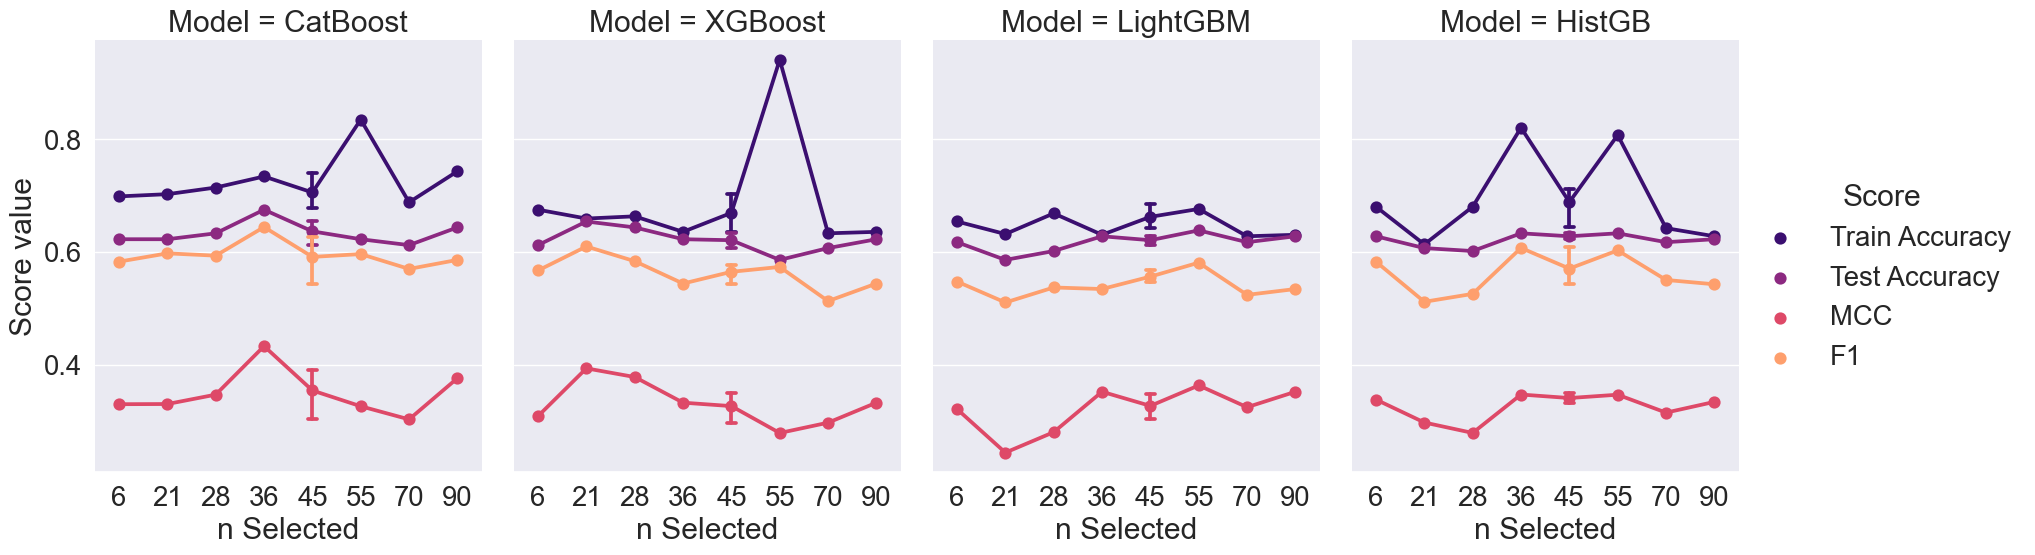

In [21]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style='whitegrid')
sns.set(font_scale=1.8)

g = sns.catplot(x="n Selected", y="Score value", hue="Score", col="Model",
                capsize=.2, palette="magma", height=6, aspect=.75,
                kind="point", data=results2)
g.despine(left=True)
plt.show()

In [22]:
models = results['Model'].unique().tolist()
temp=results.sort_values(by=['Model', 'MCC', 'F1'], ascending=False)

best_per_model_idx = []
for i in range(len(temp.index)):
    if i % (n+1) == 0: best_per_model_idx.append(temp.index[i])

**Confusion Matrix**

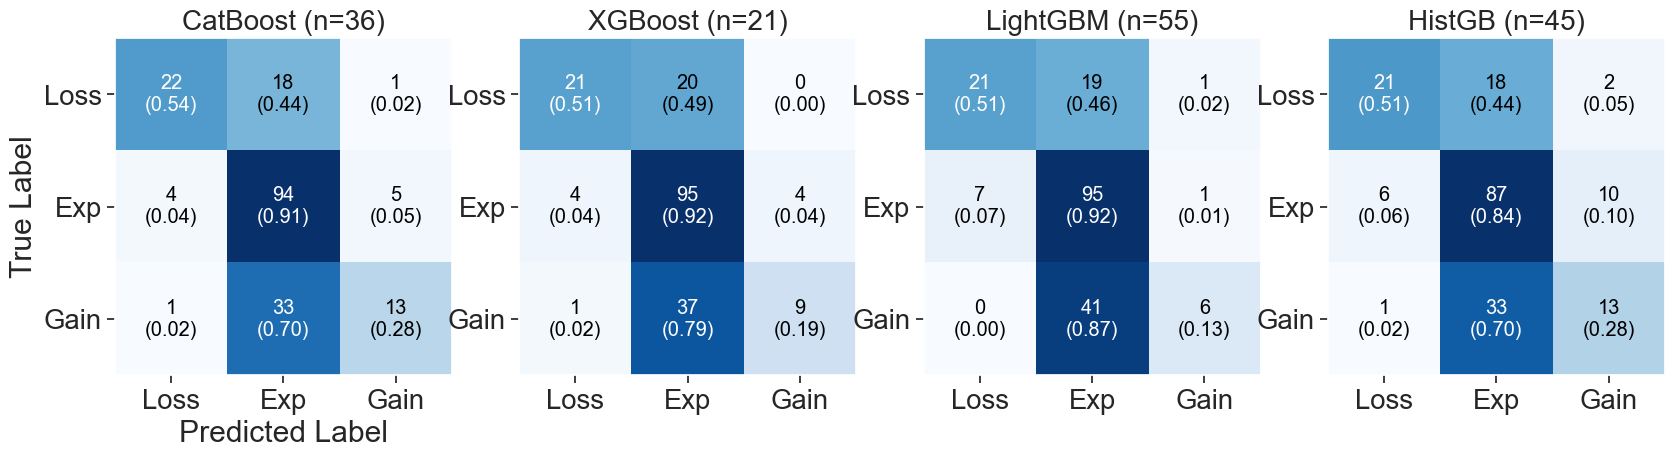

In [23]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.ticker as mticker

def ticks(x, position):
    if position == 1: return 'Loss'
    if position == 2: return 'Exp'
    if position == 3: return 'Gain'
    
fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,10))
sns.set(font_scale=1.2)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    plot_confusion_matrix(axis=axes[i], conf_mat=results.loc[idx, 'conf_mat'],
                          show_absolute=True, show_normed=True)
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    if (i > 0): axes[i].set(xlabel='', ylabel='')
    else : axes[i].set(xlabel='Predicted Label', ylabel='True Label')
    axes[i].xaxis.set_major_formatter(mticker.FuncFormatter(ticks))
    axes[i].yaxis.set_major_formatter(mticker.FuncFormatter(ticks))
plt.show()

**ROC Curve**

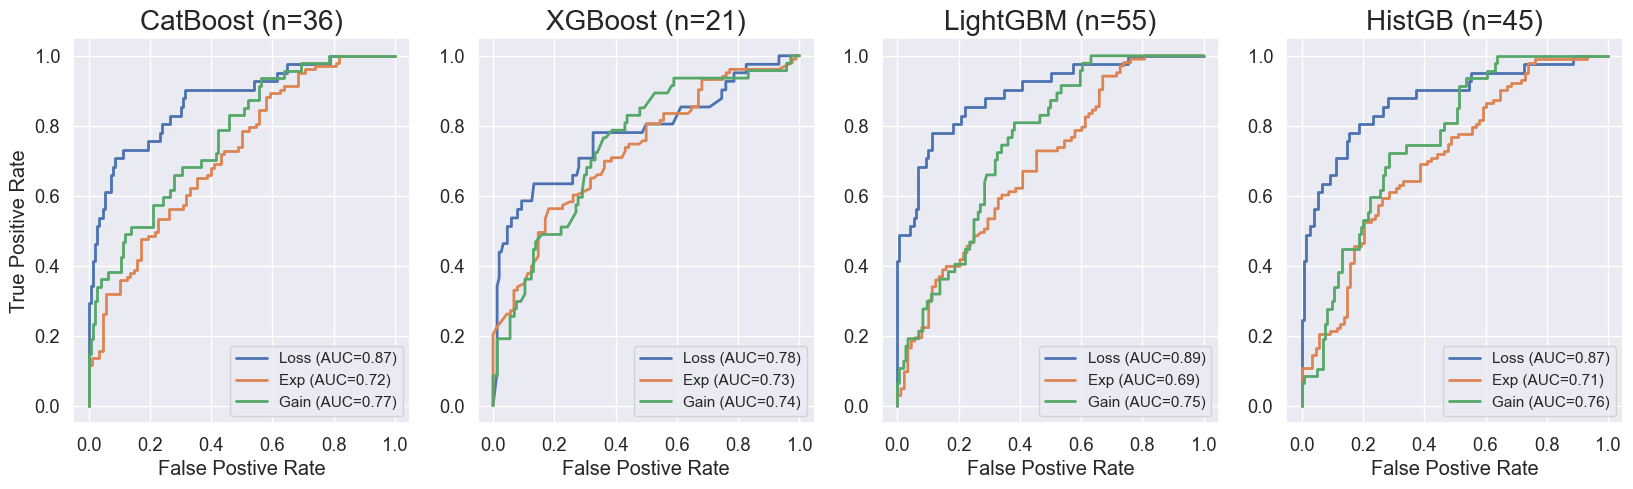

In [24]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes=[0, 1, 2]
y_test_bin=label_binarize(y_test, classes=classes)

fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,5))
sns.set(font_scale=1)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    fpr, tpr = {}, {}

    for c in classes:
        fpr[c], tpr[c], _ = roc_curve(y_test_bin[:, c], results.loc[idx, 'predict_proba'][:, c])
        axes[i].plot(fpr[c], tpr[c], lw=2, label='{} (AUC={:0.2f})'.format(ticks(c,c+1), auc(fpr[c], tpr[c])))
    
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    axes[i].set_xlabel("False Postive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[i].legend(loc="best")

plt.show()

**Precision-Recall Curve**

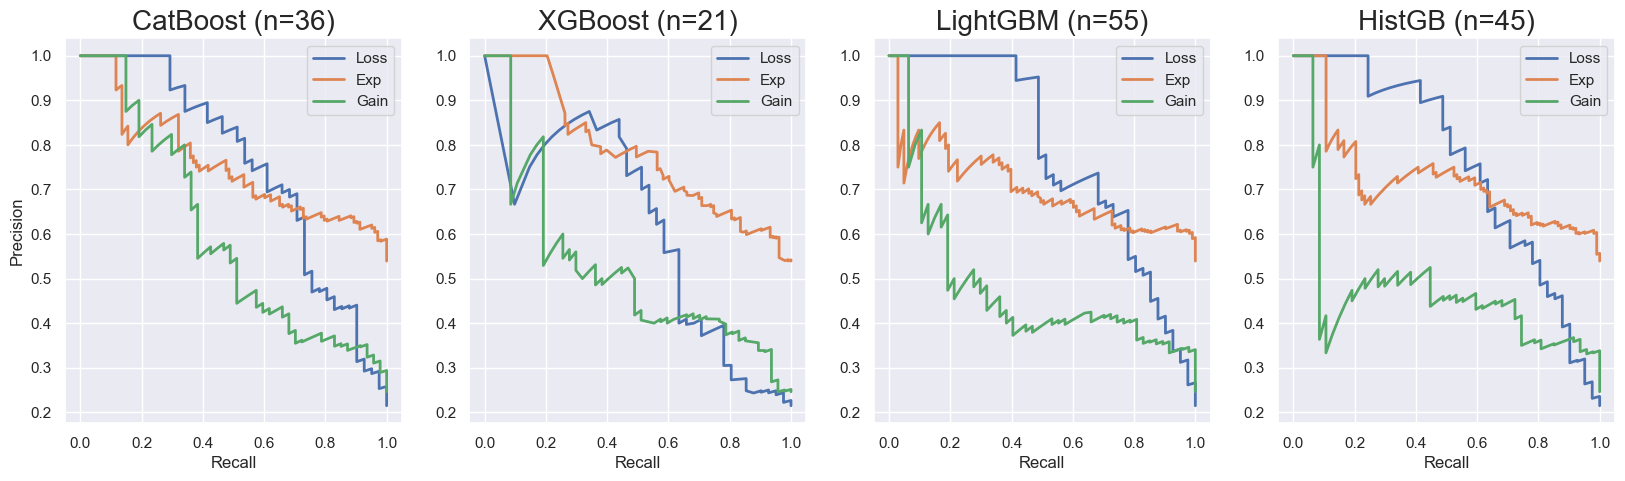

In [25]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

classes=[0, 1, 2]
y_test_bin=label_binarize(y_test, classes=classes)

fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,5))
sns.set(font_scale=1)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    prec, rec = {}, {}

    for c in classes:
        prec[c], rec[c], _ = precision_recall_curve(y_test_bin[:, c], results.loc[idx, 'predict_proba'][:, c])
        axes[i].plot(rec[c], prec[c], lw=2, label='{}'.format(ticks(c,c+1)))
    
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    axes[i].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[i].legend(loc="best")

plt.show()

In [26]:
for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    print(title, '\n', results.loc[idx, 'classification_report'])

CatBoost (n=36) 
               precision    recall  f1-score   support

           0       0.81      0.54      0.65        41
           1       0.65      0.91      0.76       103
           2       0.68      0.28      0.39        47

    accuracy                           0.68       191
   macro avg       0.72      0.58      0.60       191
weighted avg       0.69      0.68      0.64       191

XGBoost (n=21) 
               precision    recall  f1-score   support

           0       0.81      0.51      0.63        41
           1       0.62      0.92      0.75       103
           2       0.69      0.19      0.30        47

    accuracy                           0.65       191
   macro avg       0.71      0.54      0.56       191
weighted avg       0.68      0.65      0.61       191

LightGBM (n=55) 
               precision    recall  f1-score   support

           0       0.75      0.51      0.61        41
           1       0.61      0.92      0.74       103
           2       0.7

In [28]:
results.sort_values(by=['MCC'], ascending=False).to_csv('Task4_Modeling_GB_Math.csv')